<a href="https://colab.research.google.com/github/bkvkrll/-Python-Data-Science-Numpy-Matplotlib-Scikit-learn/blob/main/CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Libraries for Data Science course: Numpy, Matplotlib, Scikit-learn**

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [4]:
TRAIN_DATASET_FILE = './train.csv'
TEST_DATASET_FILE = './test.csv'
SAMPLE_SUBMISSION_FILE = './sample_submission.csv'

In [5]:
# Функция рассчета метрик
def evaluation(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train metrics",
          f"R2:\t{str(round(r2_score(train_true_values, train_pred_values), 3))}",
          f"RMSE:\t{str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3))}",
          f"MSE:\t{str(round(mse(train_true_values, train_pred_values), 3))}",
          "", sep='\n'
         )
    print("Test metrics",
          f"R2:\t{str(round(r2_score(test_true_values, test_pred_values), 3))}",
          f"RMSE:\t{str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3))}",
          f"MSE:\t{str(round(mse(test_true_values, test_pred_values), 3))}",
          "", sep='\n'
         )

    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
# Функция оптимизации памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
# Загружаем датасеты
df_train = pd.read_csv(TRAIN_DATASET_FILE)
df_test = pd.read_csv(TEST_DATASET_FILE)

In [8]:
# Проверяем количество строк и признаков в датасетах
print(f"Train:\t{df_train.shape[0]}\t sales and {df_train.shape[1]} features")
print(f'Test:\t{df_test.shape[0]}\t sales and {df_test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [9]:
df_test.head()

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
0  4567          44    1.0  ...            1        1        B
1  5925          62    1.0  ...            0        0        A
2   960          27    2.0  ...            0        1        B
3  3848          23    3.0  ...            0        0        B
4   746          74    1.0  ...            0        6        B

[5 rows x 19 columns]

# Приведение типов данных

In [10]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [12]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

In [13]:
df_train['Rooms'] = df_train['Rooms'].astype('int64')
df_test['Rooms'] = df_test['Rooms'].astype('int64')

In [14]:
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int64')
df_test['HouseFloor'] = df_test['HouseFloor'].astype('int64')

In [15]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.83 MB
Decreased by 45.6%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.19 MB
Decreased by 74.3%


In [16]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [17]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   int8    
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   int8    
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

# Проверка данных

In [18]:
all_data = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)

In [19]:
all_data.describe().transpose()

count         mean  ...          75%           max
Rooms          15000.0     1.897000  ...     2.000000  1.900000e+01
Square         15000.0    56.360554  ...    66.036606  6.410652e+02
LifeSquare     11846.0    36.851757  ...    45.144627  7.480592e+03
KitchenSquare  15000.0     6.174467  ...     9.000000  2.014000e+03
Floor          15000.0     8.561800  ...    12.000000  7.800000e+01
HouseFloor     15000.0    12.606600  ...    17.000000  1.170000e+02
HouseYear      15000.0  3321.575067  ...  2001.000000  2.005201e+07
Ecology_1      15000.0     0.119195  ...     0.195781  5.218670e-01
Social_1       15000.0    24.769267  ...    36.000000  7.400000e+01
Social_2       15000.0  5370.404933  ...  7287.000000  1.908300e+04
Social_3       15000.0     8.113667  ...     5.000000  1.410000e+02
Healthcare_1    7825.0  1144.162476  ...  1548.000000  4.849000e+03
Helthcare_2    15000.0     1.319467  ...     2.000000  6.000000e+00
Shops_1        15000.0     4.235133  ...     6.000000  2.300000e+01

[14 rows x 8 columns]

# Обзор номинативных переменных

In [20]:
cat_features = df_train.select_dtypes(include='category').columns.tolist()
cat_features

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
for col in cat_features:
    print(col, df_train[col].value_counts(), '\n', sep='\n')

Id
9999     1
15027    1
15038    1
15037    1
15036    1
        ..
4921     1
4920     1
4918     1
4916     1
0        1
Name: Id, Length: 10000, dtype: int64


DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
205      1
207      1
209      1
117      1
174      1
Name: DistrictId, Length: 205, dtype: int64


Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64


Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64


Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64




In [22]:
df_train.head()

Id DistrictId  Rooms  ...  Shops_1  Shops_2          Price
0  11809         27      3  ...        0        B  305018.875000
1   3013         22      1  ...        0        B  177734.546875
2   8215          1      3  ...        1        B  282078.718750
3   2352          1      1  ...        1        B  168106.000000
4  13866         94      2  ...        6        B  343995.093750

[5 rows x 20 columns]

# Обработка пропусков

In [23]:
df_train.isna()

Id  DistrictId  Rooms  Square  ...  Helthcare_2  Shops_1  Shops_2  Price
0     False       False  False   False  ...        False    False    False  False
1     False       False  False   False  ...        False    False    False  False
2     False       False  False   False  ...        False    False    False  False
3     False       False  False   False  ...        False    False    False  False
4     False       False  False   False  ...        False    False    False  False
...     ...         ...    ...     ...  ...          ...      ...      ...    ...
9995  False       False  False   False  ...        False    False    False  False
9996  False       False  False   False  ...        False    False    False  False
9997  False       False  False   False  ...        False    False    False  False
9998  False       False  False   False  ...        False    False    False  False
9999  False       False  False   False  ...        False    False    False  False

[10000 rows x 20 columns]

In [24]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [25]:
medians = df_train[['LifeSquare', 'Healthcare_1']].median()

In [26]:
df_train[['LifeSquare', 'Healthcare_1',]] = \
        df_train[['LifeSquare', 'Healthcare_1',]].fillna(medians)

In [27]:
df_train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

# Попробуем обучить модели на данных без предобработки, для того чтобы понять ориентиры по метрикам

In [28]:
X = df_train.drop(labels=['Price'], axis=1)
X = pd.get_dummies(data=X, columns=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], drop_first=True)
y = df_train['Price'].values

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [31]:
model_dict = {
   'lr': LinearRegression(),
#    'lasso': Lasso(random_state=42),
#    'ridge': Ridge(random_state=42),
#    'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')

lr: 
	train: 0.6578 
	valid: -7.028128864879077e+18
knn: 
	train: 0.7285 
	valid: 0.5851
dt: 
	train: 1.0 
	valid: 0.4758
rf: 
	train: 0.9616 
	valid: 0.7338


# Обработка выбросов

In [32]:
df_train.describe()

Rooms        Square  ...       Shops_1          Price
count  10000.000000  10000.000000  ...  10000.000000   10000.000000
mean       1.890500     56.315720  ...      4.231300  214138.937500
std        0.839512     21.058716  ...      4.806341   92872.273438
min        0.000000      1.136859  ...      0.000000   59174.777344
25%        1.000000     41.774879  ...      1.000000  153872.628906
50%        2.000000     52.513309  ...      3.000000  192269.648438
75%        2.000000     65.900627  ...      6.000000  249135.460938
max       19.000000    641.065186  ...     23.000000  633233.437500

[8 rows x 15 columns]

Rooms

In [33]:
df_train.Rooms.value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [34]:
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
df_train.head()

Id DistrictId  Rooms  ...  Shops_2          Price  Rooms_outlier
0  11809         27      3  ...        B  305018.875000              0
1   3013         22      1  ...        B  177734.546875              0
2   8215          1      3  ...        B  282078.718750              0
3   2352          1      1  ...        B  168106.000000              0
4  13866         94      2  ...        B  343995.093750              0

[5 rows x 21 columns]

In [35]:
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] >= 6, 'Rooms'] = df_train['Rooms'].median()

In [36]:
df_train.Rooms.value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Square

In [37]:
df_train.Square.describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

In [38]:
# Введем минимальное и максимальное знаечние площади
MIN_SQUARE = 20
MAX_SQUARE = 400

In [39]:
square_outlier_cond = (df_train.Square < MIN_SQUARE) | (df_train.Square >= MAX_SQUARE)

In [40]:
med_square_by_rooms = df_train[~square_outlier_cond]\
    .groupby('Rooms').agg({'Square': 'median'}).to_dict()['Square']
med_square_by_rooms

{1.0: 40.43838882446289,
 2.0: 55.850303649902344,
 3.0: 77.43716430664062,
 4.0: 98.66806030273438,
 5.0: 116.0848617553711}

In [41]:
df_train.loc[square_outlier_cond, 'Square'] = \
    df_train[square_outlier_cond].Rooms.map(med_square_by_rooms)

In [42]:
m = df_train.median()
m.Square

52.53953552246094

In [43]:
df_train.Square.mean(), df_train.Square.quantile(.5), df_train.shape[0]

(56.24819564819336, 52.53953742980957, 10000)

In [44]:
df_train.quantile(.025)

Rooms                1.000000
Square              32.283988
LifeSquare          15.146124
KitchenSquare        0.000000
Floor                2.000000
HouseFloor           0.000000
HouseYear         1959.000000
Ecology_1            0.000000
Social_1             1.000000
Social_2           264.000000
Social_3             0.000000
Healthcare_1        30.000000
Helthcare_2          0.000000
Shops_1              0.000000
Price            87244.381055
Rooms_outlier        0.000000
Name: 0.025, dtype: float64

In [45]:
df_train.Square.describe()

count    10000.000000
mean        56.248196
std         19.042274
min         20.213127
25%         41.783675
50%         52.539537
75%         65.905352
max        275.645294
Name: Square, dtype: float64

LifeSquare

In [46]:
df_train.LifeSquare.describe()

count    10000.000000
mean        36.266029
std         76.609962
min          0.370619
25%         25.527400
50%         32.781261
75%         41.427234
max       7480.592285
Name: LifeSquare, dtype: float64

In [47]:
df_train['LifeSquare'].quantile(.975), df_train['LifeSquare'].quantile(.025)

(78.38594131469725, 15.14612386226654)

In [48]:
condition = (df_train['LifeSquare'].isna()) \
             | (df_train['LifeSquare'] > df_train['LifeSquare'].quantile(.975))
        
df_train.loc[condition, 'LifeSquare'] = df_train['LifeSquare'].median()

df_train.loc[df_train['LifeSquare'] < 20, 'LifeSquare'] = 20
df_train.loc[df_train['LifeSquare'] > 400, 'LifeSquare'] = 400

In [49]:
df_train.LifeSquare.describe()

count    10000.000000
mean        34.312317
std         11.541984
min         20.000000
25%         25.527400
50%         32.781261
75%         39.424684
max         78.384628
Name: LifeSquare, dtype: float64

KitchenSquare

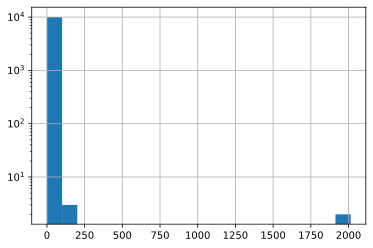

In [50]:
df_train.KitchenSquare.hist(log=True, bins=20)

In [51]:
df_train.KitchenSquare.describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [52]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [53]:
condition = (df_train['KitchenSquare'].isna()) \
             | (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975))
        
df_train.loc[condition, 'KitchenSquare'] = df_train['KitchenSquare'].median()

df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
df_train.loc[df_train['KitchenSquare'] > 100, 'KitchenSquare'] = 100

In [54]:
df_train.KitchenSquare.describe()

count    10000.000000
mean         6.238200
std          2.794661
min          3.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

Floor

In [55]:
df_train.Floor.describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

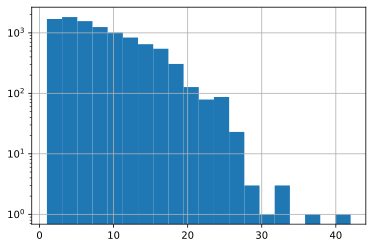

In [56]:
df_train.Floor.hist(log=True, bins=20)

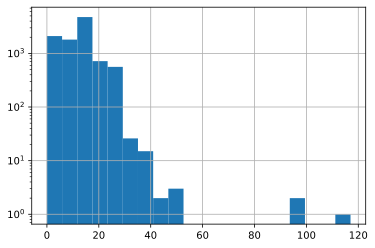

In [57]:
df_train.HouseFloor.hist(log=True, bins=20)

In [58]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [59]:
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [60]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = 1

In [61]:
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [62]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

HouseYear

In [63]:
df_train.HouseYear.describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [64]:

all_data.loc[all_data['HouseYear'] > 2021]

Id DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
8828  11607        147      2  ...            5        8        B
9163  10814        109      1  ...            3        6        B

[2 rows x 19 columns]

In [65]:
all_data.loc[all_data['HouseYear'] < 1900]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2]
Index: []

In [66]:
df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = 2021

Ecology_1	

In [67]:
df_train.Ecology_1.describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

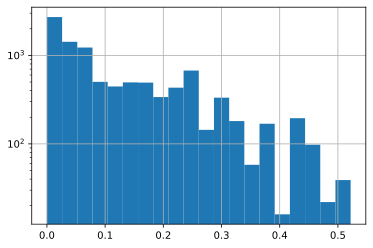

In [68]:
df_train.Ecology_1.hist(log=True, bins=20)

In [69]:
df_train.Ecology_1.quantile(.025), df_train.Ecology_1.quantile(.975)

(0.0, 0.43788525462150574)

 Social_1

In [70]:
df_train.Social_1.describe()

count    10000.000000
mean        24.687000
std         17.532614
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

In [71]:
df_train.Social_1.quantile(.025), df_train.Social_1.quantile(.975)

(1.0, 66.0)

In [72]:
condition = (df_train['Social_1'].isna()) \
             | (df_train['Social_1'] > df_train['Social_1'].quantile(.975))
        
df_train.loc[condition, 'Social_1'] = df_train['Social_1'].median()

 Social_2


In [73]:
df_train.Social_2.describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [74]:
df_train.Social_2.quantile(.025), df_train.Social_2.quantile(.975)

(264.0, 14892.0)

In [75]:
condition = (df_train['Social_2'].isna()) \
             | (df_train['Social_2'] > df_train['Social_2'].quantile(.975))
        
df_train.loc[condition, 'Social_2'] = df_train['Social_2'].median()

 Social_3

In [76]:
df_train.Social_3.describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

In [77]:
df_train.Social_3.quantile(.025), df_train.Social_3.quantile(.975)

(0.0, 93.0)

In [78]:
condition = (df_train['Social_3'].isna()) \
             | (df_train['Social_3'] > df_train['Social_3'].quantile(.975))
        
df_train.loc[condition, 'Social_3'] = df_train['Social_3'].median()

In [79]:
binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

In [80]:
df_train.head()

Id DistrictId  Rooms  ...          Price  Rooms_outlier  HouseFloor_outlier
0  11809         27    3.0  ...  305018.875000              0                   0
1   3013         22    1.0  ...  177734.546875              0                   0
2   8215          1    3.0  ...  282078.718750              0                   0
3   2352          1    1.0  ...  168106.000000              0                   0
4  13866         94    2.0  ...  343995.093750              0                   0

[5 rows x 22 columns]

In [81]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.binary_to_numbers = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

            
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # Square

        MIN_SQUARE = 20
        MAX_SQUARE = 500
        square_outlier_cond = (X['Square'] < MIN_SQUARE) | (X['Square'] >= MAX_SQUARE)
        med_square_by_rooms = X[~square_outlier_cond]\
        .groupby('Rooms').agg({'Square': 'median'}).to_dict()['Square']
        X.loc[square_outlier_cond, 'Square'] = \
        X[square_outlier_cond].Rooms.map(med_square_by_rooms)
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                          .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        X.fillna(self.medians, inplace=True)
        
        return X

Разбиение на train и test

In [82]:
target_name = 'Price'

In [83]:
train_df = pd.read_csv(TRAIN_DATASET_FILE)
test_df = pd.read_csv(TEST_DATASET_FILE)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [85]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [86]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   int64  
 11  Ecology_3           5000 non-null   int64  
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Helthcare_2         5000 non-null   int64  
 16  Shops_

In [87]:
test_df.Rooms_outlier.describe()

count    5000.00000
mean        0.00100
std         0.03161
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         1.00000
Name: Rooms_outlier, dtype: float64

In [88]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучение

In [89]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Train metrics
R2:	0.519
RMSE:	64117.097
MSE:	4111002088.658

Test metrics
R2:	0.41
RMSE:	71949.875
MSE:	5176784501.456



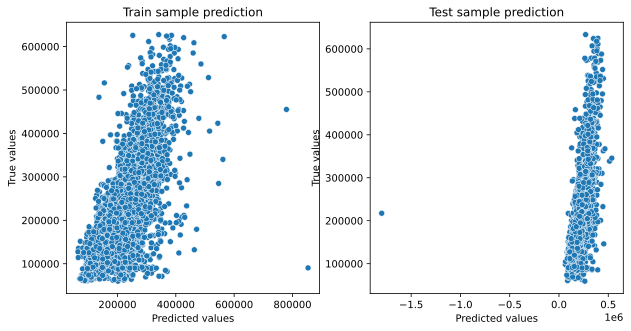

In [90]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluation(y_train, y_train_preds, y_valid, y_test_preds)

Train metrics
R2:	0.96
RMSE:	18529.582
MSE:	343345424.471

Test metrics
R2:	0.41
RMSE:	71949.875
MSE:	5176784501.456



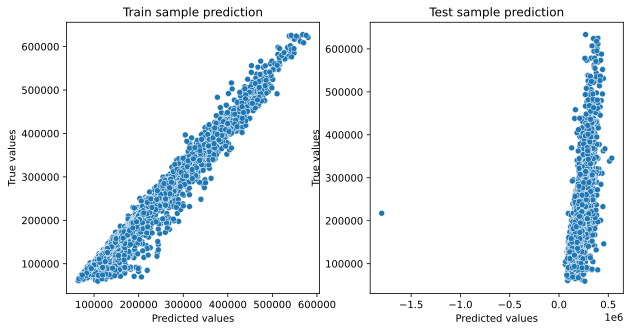

In [91]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=20,
                                 min_samples_leaf=1, 
                                 max_features=7, random_state=42)

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluation(y_train, y_train_preds, y_valid, y_test_preds)

In [92]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr_model), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('rf',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=20,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                   

Train metrics
R2:	0.953
RMSE:	20064.968
MSE:	402602951.672

Test metrics
R2:	0.743
RMSE:	47517.307
MSE:	2257894490.935



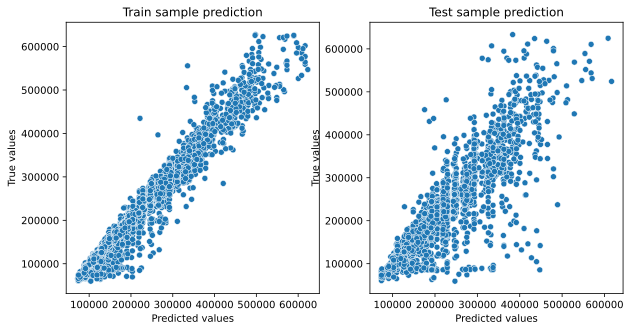

In [93]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluation(y_train, y_train_preds, y_valid, y_test_preds)

In [94]:
cv_score = cross_val_score(stack, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71552796, 0.67596863, 0.72611283])

In [95]:
cv_score.mean()

0.7058698055565898

In [96]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
3               Square    0.274578
2                Rooms    0.118521
13            Social_2    0.088119
4           LifeSquare    0.085741
12            Social_1    0.072142
14            Social_3    0.062989
1           DistrictId    0.052984
8            HouseYear    0.040454
9            Ecology_1    0.040321
5        KitchenSquare    0.030690
7           HouseFloor    0.028199
16             Shops_1    0.027685
0                   Id    0.026346
6                Floor    0.021430
15         Helthcare_2    0.020294
19  HouseFloor_outlier    0.003299
21      LifeSquare_nan    0.003076
17             Shops_2    0.001364
11           Ecology_3    0.001291
10           Ecology_2    0.000356
18       Rooms_outlier    0.000116
20   HouseYear_outlier    0.000008

In [97]:
test_df.shape

(5000, 22)

In [98]:
test_df

Id  DistrictId  ...  HouseYear_outlier  LifeSquare_nan
0      4567          44  ...                  0               0
1      5925          62  ...                  0               0
2       960          27  ...                  0               1
3      3848          23  ...                  0               0
4       746          74  ...                  0               1
...     ...         ...  ...                ...             ...
4995  10379          29  ...                  0               0
4996  16138          38  ...                  0               0
4997   3912         101  ...                  0               0
4998   5722          10  ...                  0               0
4999  11004          21  ...                  0               0

[5000 rows x 22 columns]

In [99]:
submit = pd.read_csv(SAMPLE_SUBMISSION_FILE)
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [100]:
predictions = stack.predict(test_df)
predictions

array([161731.9660653 , 119338.8573293 , 141196.89274519, ...,
       145996.03317739, 191763.80521195, 266894.80779994])

In [101]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  161731.966065
1  5925  119338.857329
2   960  141196.892745
3  3848  131268.775810
4   746  220651.424631

In [102]:
submit.to_csv('rf_submit.csv', index=False)